# Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Settings

## Data

In [2]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set(style='ticks', rc=custom_params, font_scale=1.5)
path = os.path.join('assets', 'datasets')
os.chdir(path)

df = pd.read_parquet('./Sleep_health_and_lifestyle_dataset_preprocessed.parquet')

## Translate values

In [3]:
# ----------------------
# | column index names |
# ----------------------
new_names = ['Person ID', 'Sesso', 'Età', 'Occupazione lavorativa',
             'Durata del sonno', 'Qualità del sonno', 'Livello di attività fisica',
             'Livello di stress', 'BMI', 'Heart Rate', 'Passi giornalieri',
             'Disturbi del sonno', 'Pressione sanguigna sistolica', 'Pressione sanguigna diastolica']
columns = dict()

for x in range( len(df.columns.values) ):
    columns[df.columns[x]] = new_names[x] 


df = df.rename( columns=columns )

# ---------------
# | cell values |
# ---------------

# bmi
values = {'Normal Weight': 'normopeso',
         'Overweight': 'sovrappeso',
         'Obese': 'obeso'}
df['BMI'] = df['BMI'].map(values)

# sleep disorders
values = {'None': 'nessuno',
         'Sleep Apnea': 'apnea',
         'Insomnia': 'insonnia'}
df['Disturbi del sonno'] = df['Disturbi del sonno'].map(values)

## Global variables

In [4]:
def get_color_ordered_list(*args):
    l, *order = args
    return [ l[x] for x in order ]


# estetics order
order_est_bmi = [ 'normopeso', 'sovrappeso', 'obeso' ]
order_est_sleep_dis = [ 'nessuno', 'apnea', 'insonnia' ]

# palettes
# global palette
colors = sns.color_palette('muted').as_hex()
label_colors = sns.color_palette('dark').as_hex()

color_pos = [2, 0, 1, 5, 4, 3]
default_colors = get_color_ordered_list(colors, *color_pos)
label_colors = get_color_ordered_list(label_colors, *color_pos)

sns.set_palette( sns.color_palette( default_colors ) )

# bmi palette
bmi_palette = { order_est_bmi[x]: default_colors[x] for x in range(3) }

# annotate bmi palette
label_bmi_palette = { order_est_bmi[x]: label_colors[x] for x in range(3) }

# sleep disorders palette
sleep_dis_palette = { order_est_sleep_dis[x]: default_colors[x+3] for x in range(3) }


# Functions

In [5]:
def bmi_sleep_quality_plot():
    global bmi_palette, order_est_bmi, label_bmi_palette, sleep_dis_palette

    order_est = order_est_bmi.copy()
    
    ax = sns.boxplot(df, x='Qualità del sonno', y='BMI', hue='BMI', palette=bmi_palette,
                   order=order_est, hue_order=order_est, legend=False, medianprops={'color': 'black', 'linewidth': 8})
    
    ax.set_title('Distribuzione del BMI sulla qualità del sonno')
    
    # legend
    ax.plot([], [], color='k', linestyle='dashed', linewidth=10, label='mediana')
    ax.legend(loc = 'upper right', bbox_to_anchor=(1.4, .9))

    return ax


def show_multiple_plots(df, x, y, division, x_pos, y_pos, title, highlight=None):
    global bmi_palette, order_est_bmi, label_bmi_palette

    order_est = order_est_bmi.copy()
    
    # set palette
    if highlight:
        temp_palette = {'normopeso': 'gray', 'sovrappeso': 'gray', 'obeso': 'gray'}
        temp_palette[highlight] = bmi_palette[highlight]
        est_palette = temp_palette.copy()
        temp_palette[highlight] = label_bmi_palette[highlight]
        lab_palette = temp_palette.copy()
    else:
        est_palette = bmi_palette.copy()
        lab_palette = label_bmi_palette.copy()
    
    # filter data
    df_grouped = df.groupby(division)[ [x, y] ].value_counts()
    df_filtered = df_grouped.reset_index()
    df_filtered = df_filtered.rename( columns=({'count': 'numero di persone'}) )
    
    # create graph
    g = sns.relplot(data=df_filtered, x=x, y=y, col=division, hue=division,
                    size='numero di persone', sizes=(70, 300), hue_order=order_est,
                    col_order=order_est, palette=est_palette, legend=True)
    g.map_dataframe(sns.regplot, x=x, y=y, truncate=False, scatter=False, ax=g.axes, color = '0.8')

    # set legend
    g.legend.remove()
    handles, labels = g.axes[0][0].get_legend_handles_labels()
    add_legend(g, handles[:4], labels[:4], 'right', 'upper', .5, -0.1)
    add_legend(g, handles[4:], labels[4:], 'left', 'upper', .5, -0.1)
    
    # add annotations
    corr = calculate_correlation(df, x, y, division)

    if highlight:
        r = corr[highlight]['r']
        p = corr[highlight]['p']
        
        text = r'$\mathbf{\rho}$ = ' + f'{r: .3f}\t' + f'\np-value = {p: .1e}'
        g.axes_dict[highlight].annotate(text=text, xy=(x_pos, y_pos), size='large', weight='bold',
                                  bbox={'boxstyle': 'round', 'fc': '#ededed', 'pad': .2},
                                  color=lab_palette[highlight])
    else:
        for col in df[division].unique():
            r = corr[col]['r']
            p = corr[col]['p']
            
            text = r'$\mathbf{\rho}$ = ' + f'{r: .3f}\t' + f'\np-value = {p: .1e}'
            g.axes_dict[col].annotate(text=text, xy=(x_pos, y_pos), size='large', weight='bold',
                                      bbox={'boxstyle': 'round', 'fc': '#ededed', 'pad': .2},
                                      color=lab_palette[col])

    g.fig.suptitle(title)
    g.fig.tight_layout()
    return g



def calculate_correlation(df, x, y, col_cat):
    list_cat = df[col_cat].unique()
    all_correlations = dict()
    
    for cat in list_cat:
        df_cat = df[ df[col_cat] == cat ]
        corr = stats.linregress(df_cat[x], df_cat[y])
        
        single_correlation = dict()
        single_correlation['r'] = corr.rvalue
        single_correlation['p'] = corr.pvalue
        single_correlation['slope'] = corr.slope
        all_correlations[ cat ] = single_correlation
        
    return all_correlations


def show_number_people_sleep_disorders(ax, bmi):
    global sleep_dis_palette, order_est_sleep_dis

    order_est = order_est_sleep_dis.copy()
    palette = sleep_dis_palette.copy()
    
    # manage data
    df_sliced = df[ ['BMI', 'Disturbi del sonno'] ]
    m_normal_weight = df_sliced['BMI'] == bmi
    df_filtered = df_sliced[ m_normal_weight ]
    df_filtered = df_filtered.value_counts().reset_index()
    df_filtered = df_filtered.rename( columns={'count': 'numero di persone'} )

    ax = sns.barplot(data=df_filtered, x='Disturbi del sonno', y='numero di persone',
                     hue='Disturbi del sonno', order=order_est, hue_order=order_est,
                     palette=palette, ax=ax)
    
    ax.set_title(f'BMI: {bmi}')
    
    return ax
    

def add_legend(ax, handles, labels, pos_x, pos_y, pos_anchor_x, pos_anchor_y):
    # create legend
    dict_legend = { labels[x]: handles[x] for x in range(1, len(labels)) }
    
    # add legend
    ax.add_legend(legend_data=dict_legend, title=labels[0])
    ax = sns.move_legend(ax, f'{pos_y} {pos_x}', bbox_to_anchor=(pos_anchor_x, pos_anchor_y), frameon=True)
    return ax

# Dormire bene è importante
## Per quale motivo dovremmo dormire meglio?

- ridurre il rischio di infezzioni
- migliorare la memoria
- rinforzare le capacità cognitive
- eliminare le scorie nel nostro corpo

In [6]:
from IPython.display import display, Markdown

display(Markdown('# L\'IBM influenza la qualità del sonno?'))

for x in range(3):
    display(Markdown(f'- <font color=\'{default_colors[x]}\'>{ order_est_bmi[x] }</font>'))


# L'IBM influenza la qualità del sonno?

- <font color='#6acc64'>normopeso</font>

- <font color='#4878d0'>sovrappeso</font>

- <font color='#ee854a'>obeso</font>

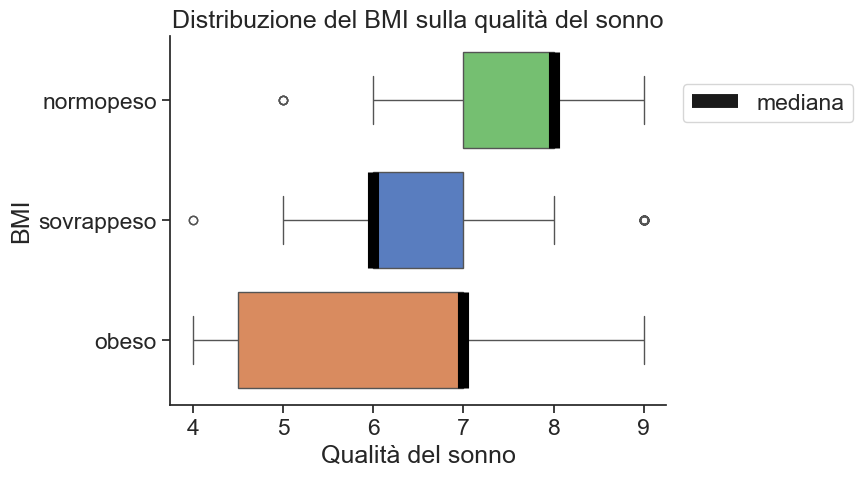

In [7]:
bmi_sleep_quality_plot();

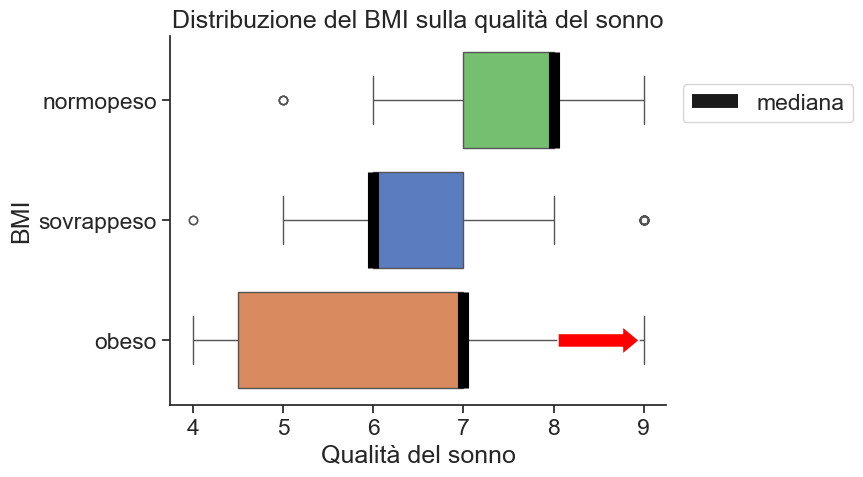

In [17]:
ax = bmi_sleep_quality_plot()

dict_arrow = dict(facecolor='red', shrink = 0.05, width=10, headwidth=20)
ax.annotate('', xy=(9, 'obeso'), xytext=(8, 'obeso'), arrowprops=dict_arrow);

# Livello di stress

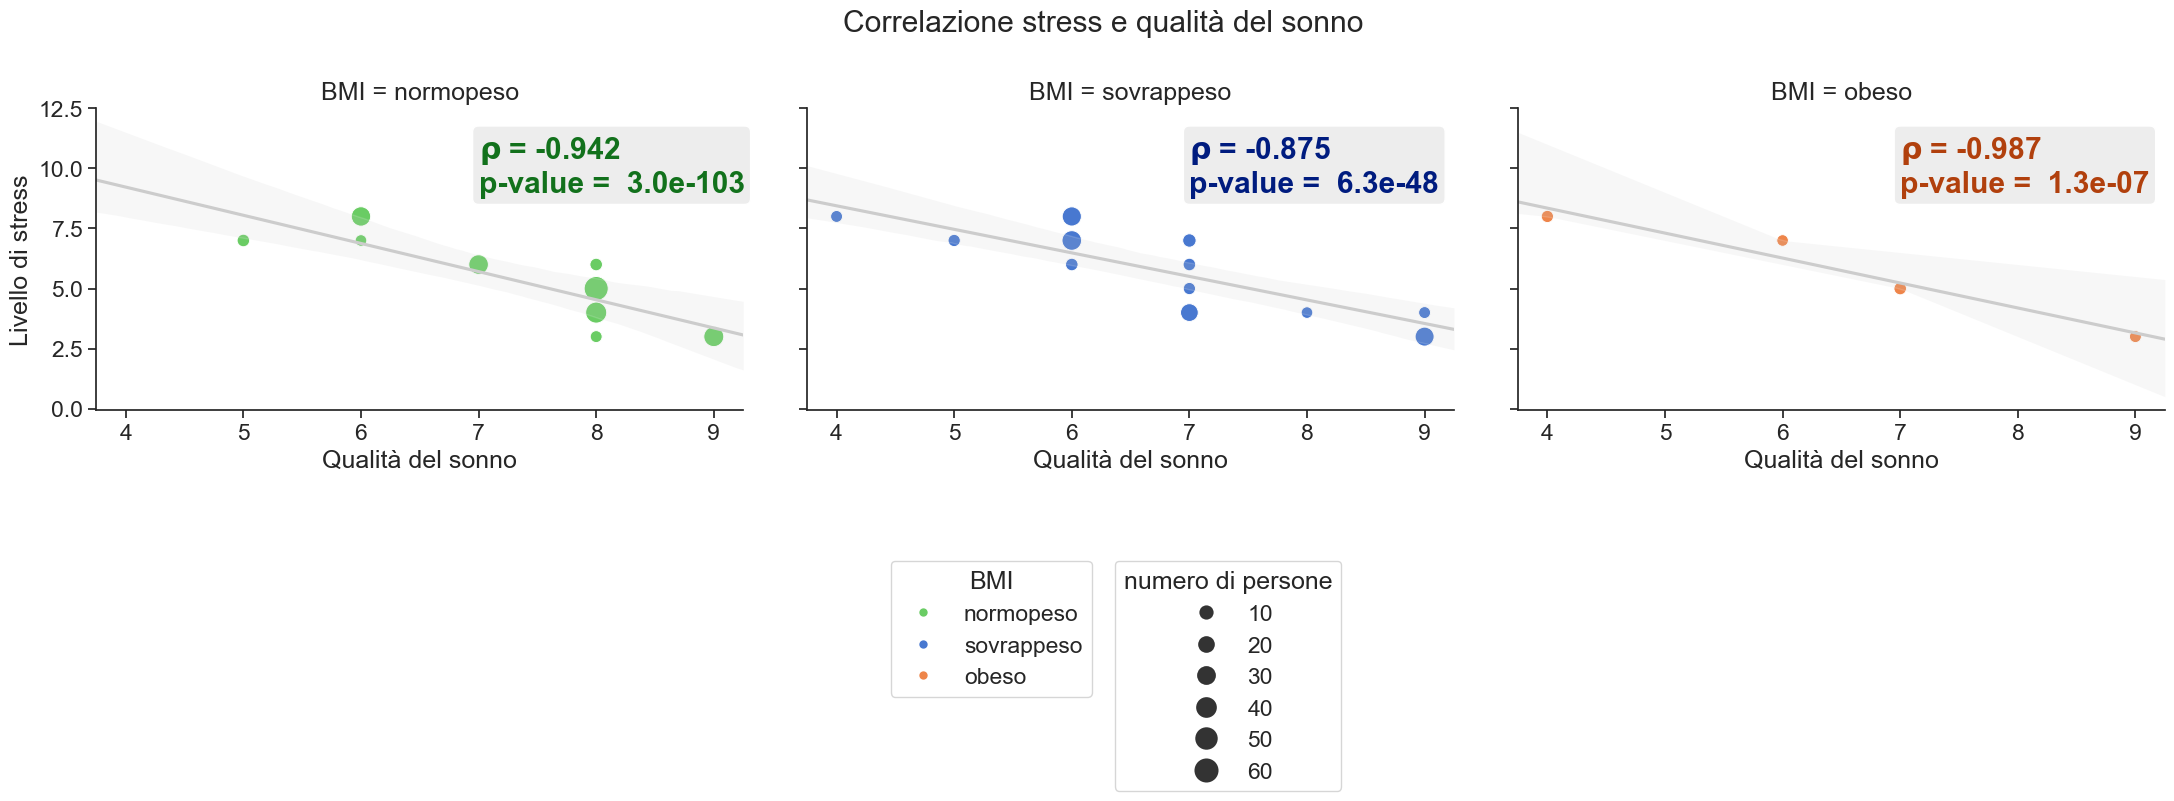

In [9]:
show_multiple_plots(df, 'Qualità del sonno', 'Livello di stress', 'BMI', 7, 9,
                        'Correlazione stress e qualità del sonno');

# Durata del sonno

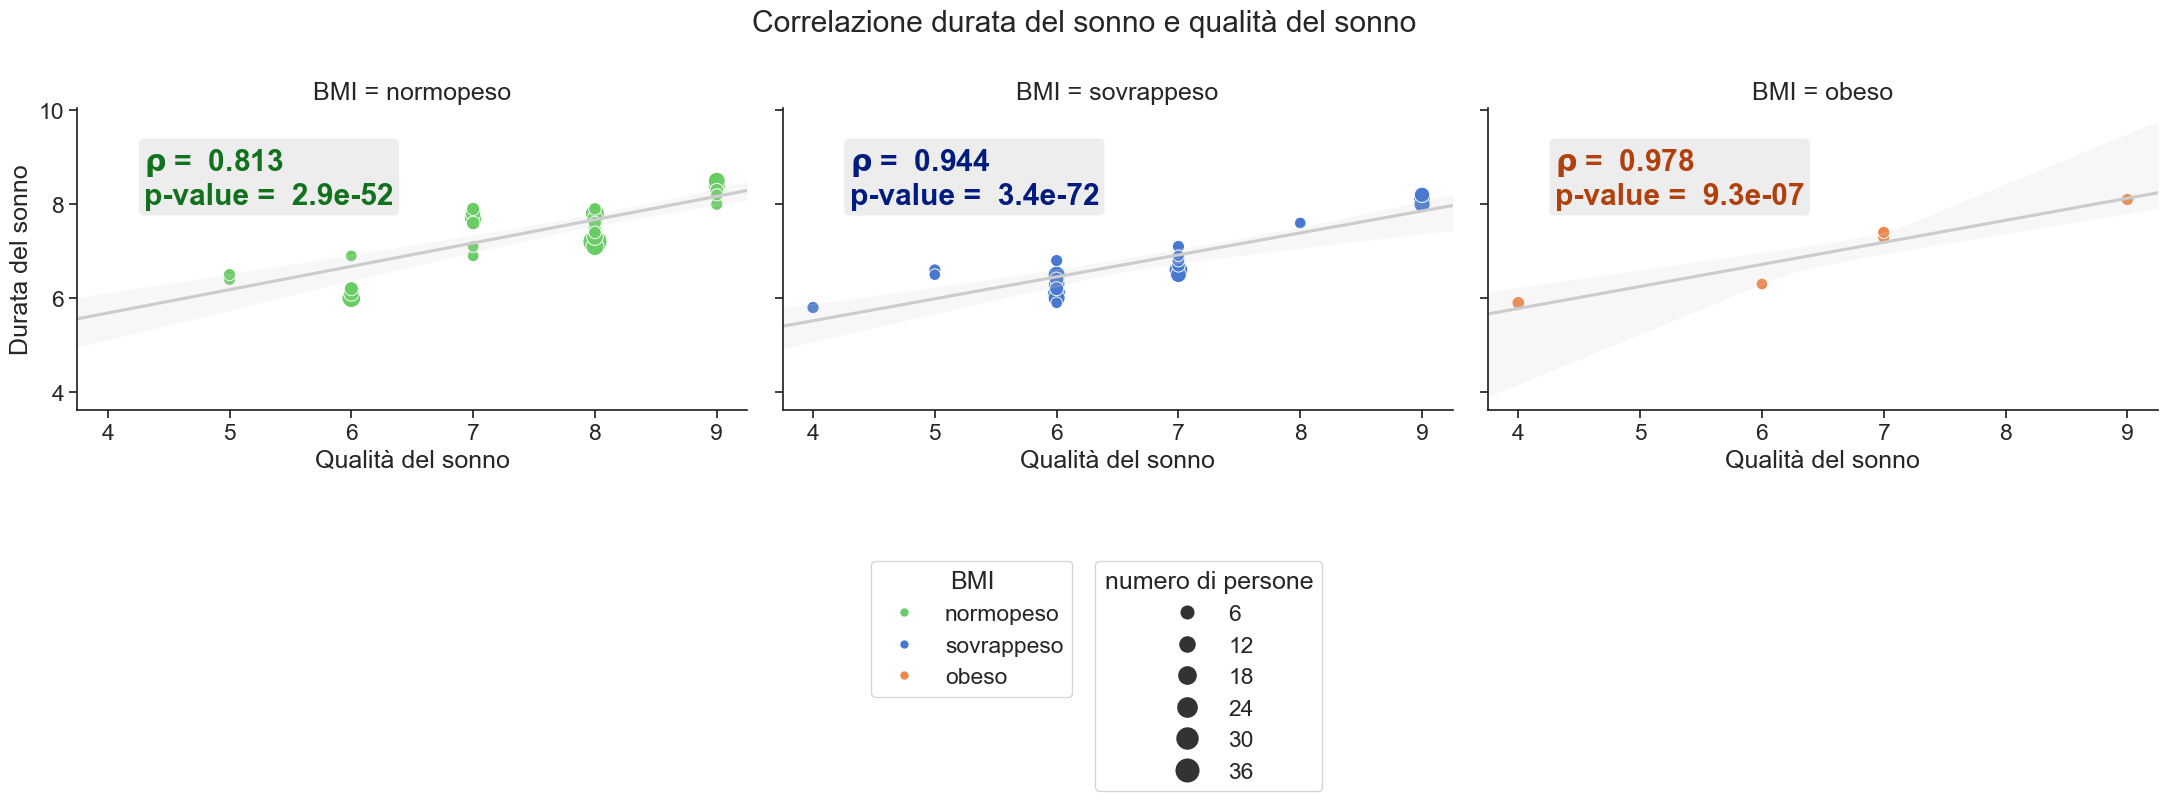

In [10]:
show_multiple_plots(df, 'Qualità del sonno', 'Durata del sonno', 'BMI', 4.3, 8,
                        'Correlazione durata del sonno e qualità del sonno');

# Durata del sonno e stress

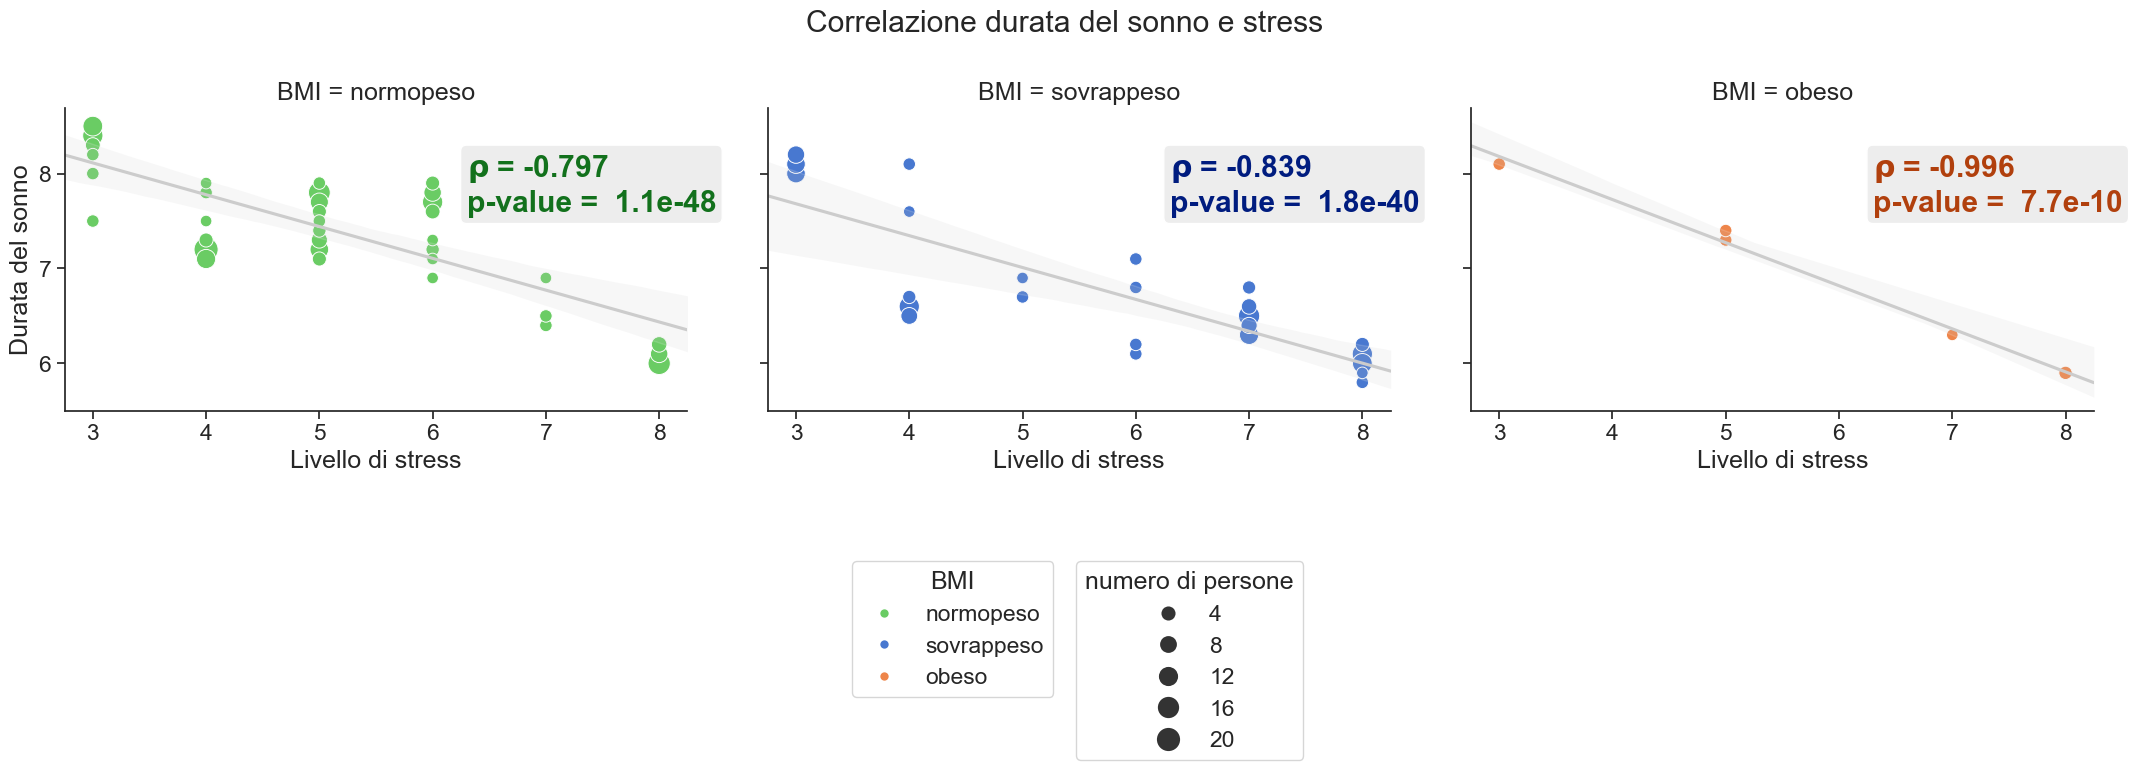

In [11]:
show_multiple_plots(df, 'Livello di stress', 'Durata del sonno', 'BMI', 6.3, 7.6,
                       'Correlazione durata del sonno e stress');

# L'attività fisica

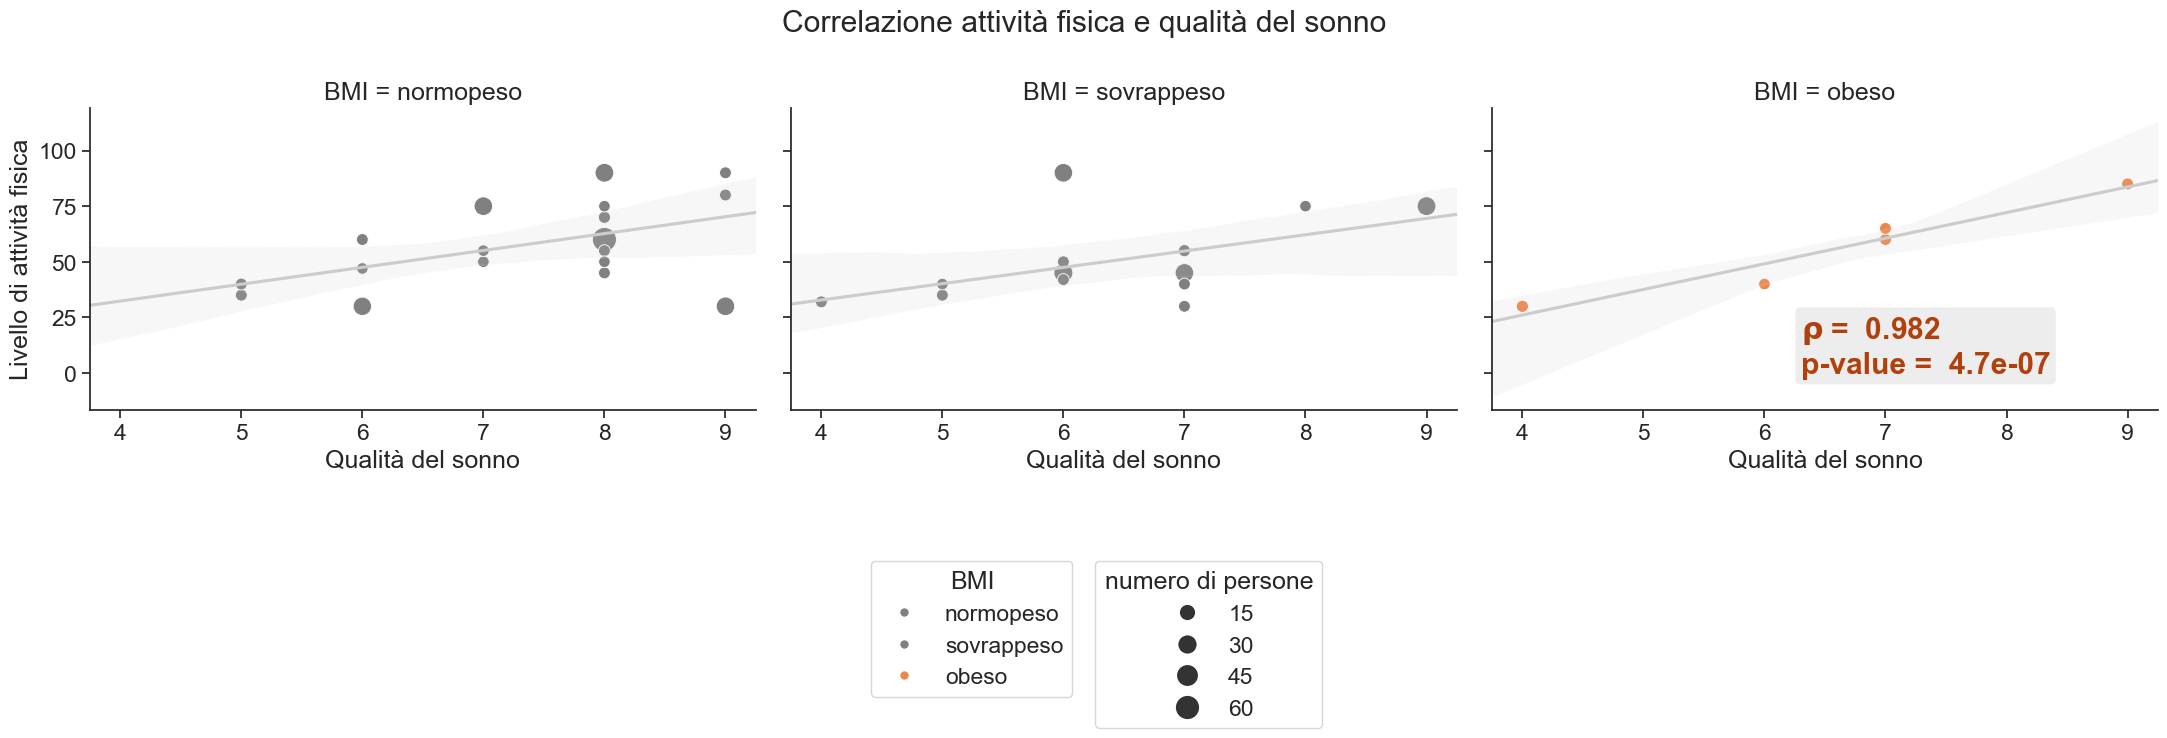

In [12]:
show_multiple_plots(df, 'Qualità del sonno', 'Livello di attività fisica', 'BMI', 6.3, 0,
                        'Correlazione attività fisica e qualità del sonno', 'obeso');

# L'attività fisica

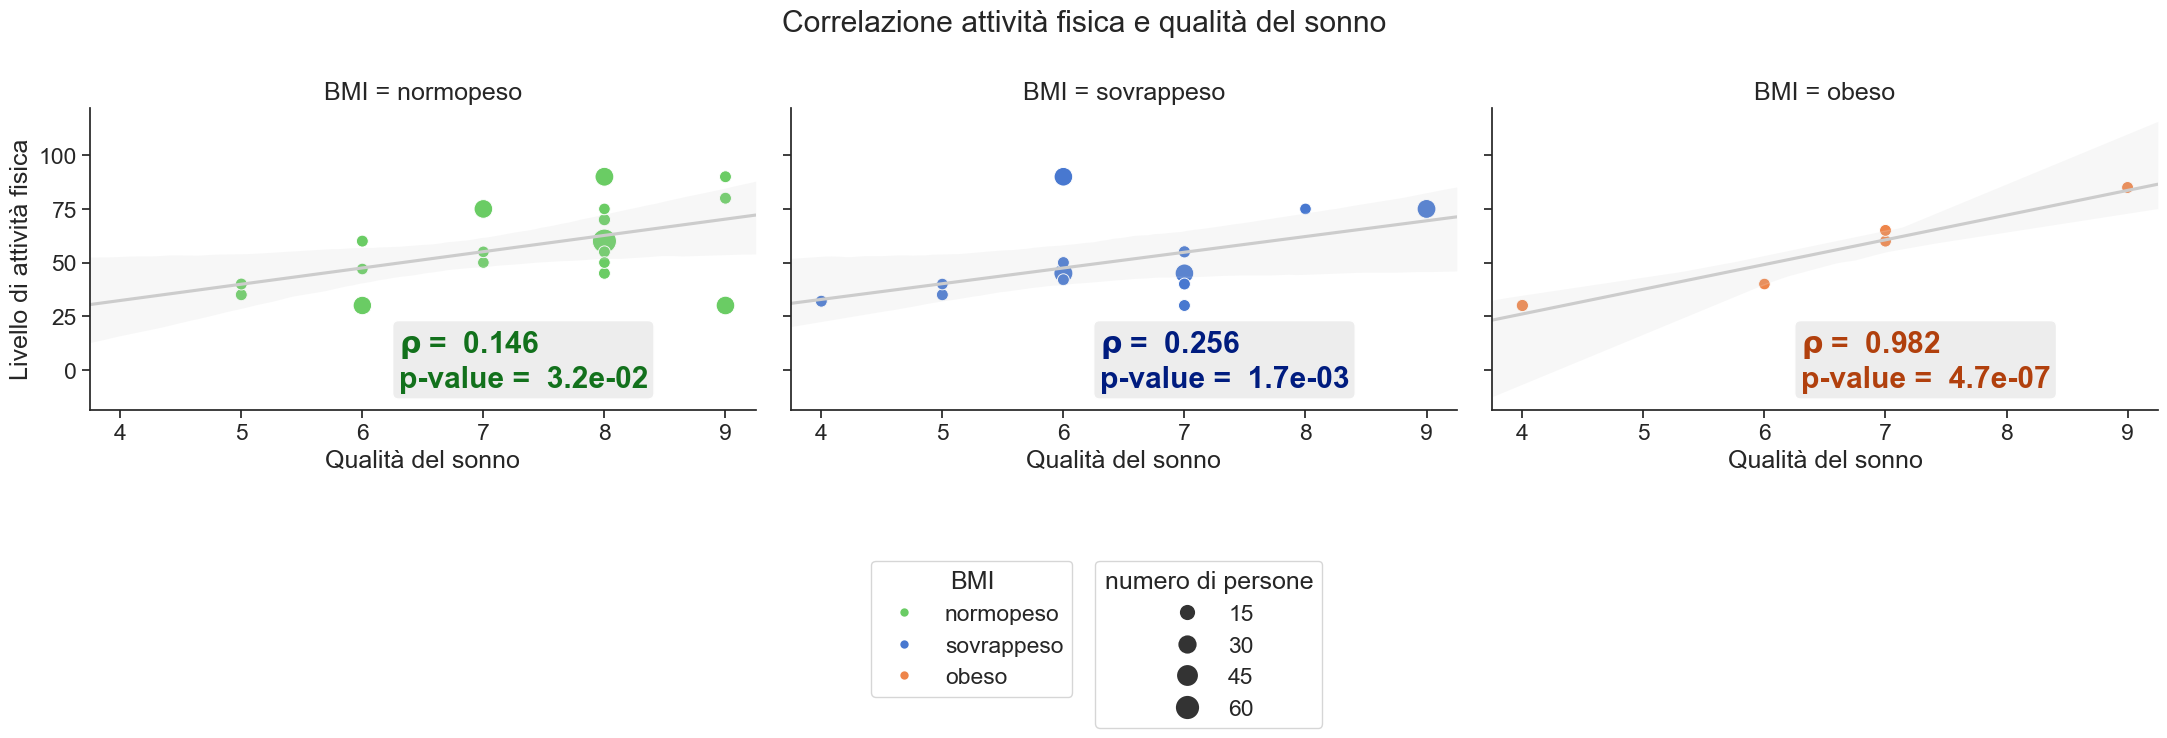

In [13]:
show_multiple_plots(df, 'Qualità del sonno', 'Livello di attività fisica', 'BMI', 6.3, -8,
                        'Correlazione attività fisica e qualità del sonno');

# Invecchiando migliorerà o peggiorerà la qualità del sonno?

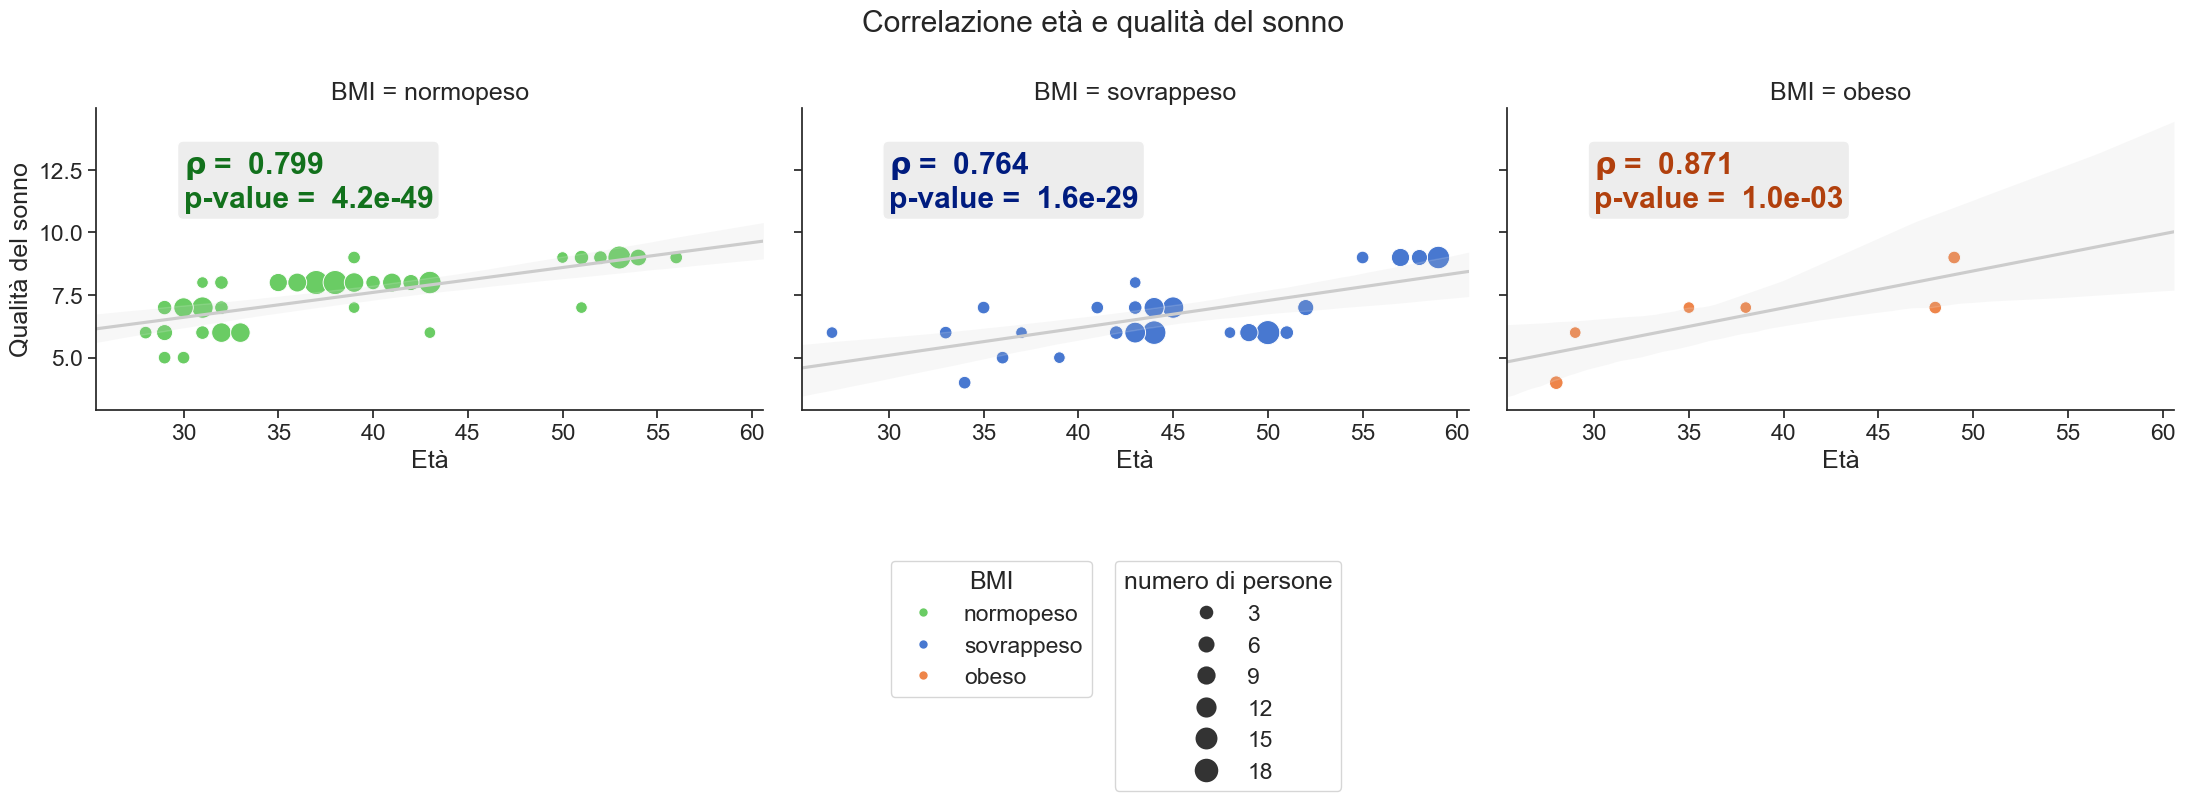

In [14]:
show_multiple_plots(df, 'Età', 'Qualità del sonno', 'BMI', 30, 11,
                       'Correlazione età e qualità del sonno');

In [15]:
from IPython.display import display, Markdown

display(Markdown('# Come capire se abbiamo disturbi del sonno?'))

for x in range(3):
    display(Markdown(f'- <font color=\'{ default_colors[x+3] }\'>{order_est_sleep_dis[x]}</font>'))


# Come capire se abbiamo disturbi del sonno?

- <font color='#8c613c'>nessuno</font>

- <font color='#956cb4'>apnea</font>

- <font color='#d65f5f'>insonnia</font>

# BMI

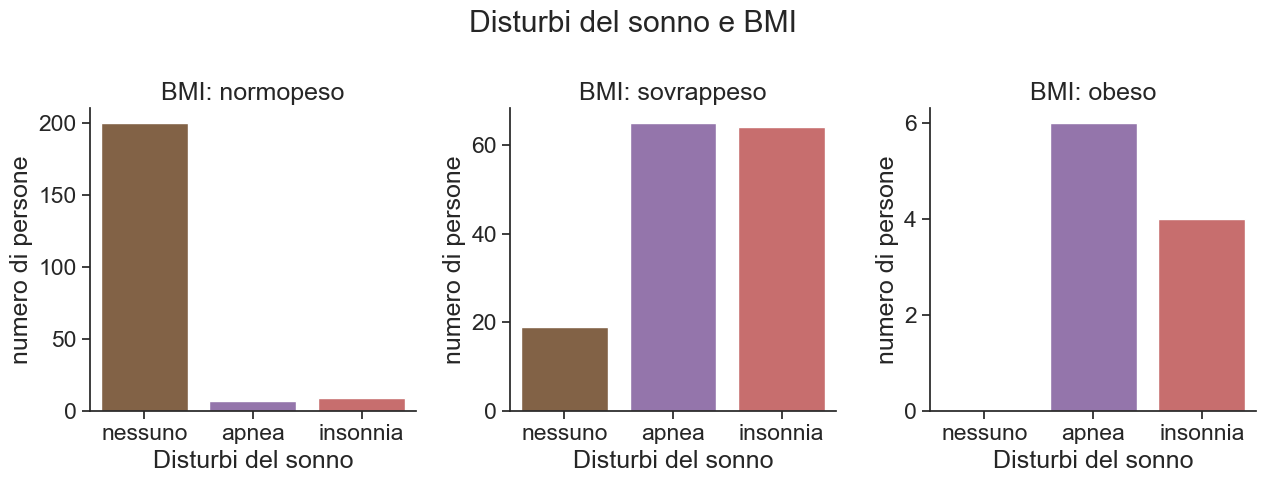

In [16]:
fig, (ax_sx, ax_cx, ax_dx) = plt.subplots(1, 3, figsize=(13, 5))

show_number_people_sleep_disorders(ax_sx, 'normopeso')
show_number_people_sleep_disorders(ax_cx, 'sovrappeso')
show_number_people_sleep_disorders(ax_dx, 'obeso')

fig.suptitle('Disturbi del sonno e BMI')

fig.tight_layout()

# Takeaways

- l'attività fisica aiuta le persone obese
- al crescere dell'età c'è un miglioramento della qualità del sonno
- il BMI è una misura abbastanza affidabile per sapere se abbiamo disturbi del sonno
- la qualità del sonno è influenzata da molti fattori

# Dataset
Dataset form [Kaggle](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset) by [Laksika Tharmalingam
](https://www.kaggle.com/uom190346a)